# Walmart Sales Projection using Recurrent Neural Network -One Store

1. Show data cleaning and preparation steps

2. Perform EDA on the given dataset and list out findings ( performed on previous report on week 3)

3. Predict the sales projection with multivariate recurrent neural network algorithms - Use R square and MAE as metrics and provide best possible accuracy. (98% accuray and MAE of 2K-2.5K)



In [146]:
# Importing neccessary Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

import seaborn as sns
import os
from scipy import stats
%matplotlib inline
#import datetime

os.getcwd()

'/content'

In [2]:
# import data from local
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving stores.csv to stores.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
Saving walmart features.csv to walmart features.csv
User uploaded file "stores.csv" with length 1027 bytes
User uploaded file "test.csv" with length 4110769 bytes
User uploaded file "train.csv" with length 16828140 bytes
User uploaded file "walmart features.csv" with length 680783 bytes


# 1. Data Cleaning and preparation steps

In [0]:
# Load dataset
data_features = pd.read_csv('walmart features.csv')
data_stores = pd.read_csv('stores.csv')
data_training = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [477]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)
data_training.head()

,Unnamed: 0,index,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,0.0,1,1,2/5/2010,24924.50,0
1,2,1.0,1,1,2/12/2010,46039.49,1
2,3,2.0,1,1,2/19/2010,41595.55,0
3,4,3.0,1,1,2/26/2010,19403.54,0
4,5,4.0,1,1,3/5/2010,21827.90,0


In [478]:
data_training.shape

(421570, 7)

In [479]:
data_training.dtypes

Unnamed: 0        int64
index           float64
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday         int64
dtype: object

In [480]:
data_training.nunique()

Unnamed: 0      421570
index           421570
Store               45
Dept                81
Date               143
Weekly_Sales    359455
IsHoliday            2
dtype: int64

In [0]:
data_training = data_training.iloc[:,1:]
data_features = data_features.iloc[:,2:]
data_stores = data_stores.iloc[:,1:]


In [0]:
data_training['Date'] = pd.to_datetime(data_training['Date'])
data_features['Date'] = pd.to_datetime(data_features['Date'])
#data_training['Category'] = 'Train'
#data_test['Category'] = 'Test'
#data_test['Weekly_Sales'] = 0


In [0]:
data_features['CPI'].fillna(data_features['CPI'].mean(), inplace=True)
data_features['Unemployment'].fillna(data_features['Unemployment'].mean(), inplace=True)

In [484]:
data_features.drop(columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis = 1, inplace=True)
data_features.head()


,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,211.096358,8.106,0
1,1,2010-02-12,38.51,2.548,211.242170,8.106,1
2,1,2010-02-19,39.93,2.514,211.289143,8.106,0
3,1,2010-02-26,46.63,2.561,211.319643,8.106,0
4,1,2010-03-05,46.50,2.625,211.350143,8.106,0


In [485]:
data_stores.head()

,index,Store,Type,Size
0,0,1,A,151315
1,1,2,A,202307
2,2,3,B,37392
3,3,4,A,205863
4,4,5,B,34875


In [486]:
print("data_store:\n ", data_stores.dtypes)
print("data_feautres:\n ", data_features.dtypes)
print("data_training:\n ", data_training.dtypes)

data_store:
  index     int64
Store     int64
Type     object
Size      int64
dtype: object
data_feautres:
  Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
IsHoliday                int64
dtype: object
data_training:
  index                  float64
Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int64
dtype: object


In [0]:
train_bt = pd.merge(data_training, data_stores, on= ['Store'], how='left')

train = pd.merge(train_bt,data_features, on=['Store', 'Date', 'IsHoliday'], how = 'left')

In [488]:
train.head()

,index_x,Store,Dept,Date,Weekly_Sales,IsHoliday,index_y,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,0.0,1,1,2010-02-05,24924.50,0,0,A,151315,42.31,2.572,211.096358,8.106
1,1.0,1,1,2010-02-12,46039.49,1,0,A,151315,38.51,2.548,211.242170,8.106
2,2.0,1,1,2010-02-19,41595.55,0,0,A,151315,39.93,2.514,211.289143,8.106
3,3.0,1,1,2010-02-26,19403.54,0,0,A,151315,46.63,2.561,211.319643,8.106
4,4.0,1,1,2010-03-05,21827.90,0,0,A,151315,46.50,2.625,211.350143,8.106


In [0]:
train.drop(columns=["index_y"],axis =1, inplace = True )


In [490]:
train.index_x.astype(int)

0              0
1              1
2              2
3              3
4              4
           ...  
421565    421565
421566    421566
421567    421567
421568    421568
421569    421569
Name: index_x, Length: 421570, dtype: int64

In [0]:
train['Weekly_Sales'] = np.where(train['Weekly_Sales'] < 0, 0, train['Weekly_Sales'])

In [492]:
train["index_x"].astype(int)
train.head()

,index_x,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,0.0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,211.096358,8.106
1,1.0,1,1,2010-02-12,46039.49,1,A,151315,38.51,2.548,211.242170,8.106
2,2.0,1,1,2010-02-19,41595.55,0,A,151315,39.93,2.514,211.289143,8.106
3,3.0,1,1,2010-02-26,19403.54,0,A,151315,46.63,2.561,211.319643,8.106
4,4.0,1,1,2010-03-05,21827.90,0,A,151315,46.50,2.625,211.350143,8.106


In [0]:
store_dept_summary = data_training.groupby(by=['Store','Dept']).agg(
    {
        'Date': [min,max],
        'Weekly_Sales': "count" 

    }


)



In [494]:
store_dept_summary.head()

Date            Weekly_Sales
                  min        max        count
Store Dept                                   
1     1    2010-02-05 2012-10-26          143
      2    2010-02-05 2012-10-26          143
      3    2010-02-05 2012-10-26          143
      4    2010-02-05 2012-10-26          143
      5    2010-02-05 2012-10-26          143

In [495]:
store_dept_summary.columns

MultiIndex([(        'Date',   'min'),
            (        'Date',   'max'),
            ('Weekly_Sales', 'count')],
           )

In [0]:
train['Weeks_since_start'] = round(pd.to_numeric((train['Date'] - pd.to_datetime('2010-02-05')) / np.timedelta64(1, 'W')))
train['week_number_of_year'] = train['Date'].dt.week
#train['PreWeekDate'] = pd.to_datetime(data_features['Date']) - datetime.timedelta(days = 7)



In [497]:
#train['NewHoliday_Ind'] = np.where((train['IsHoliday'] == 0), 0, 1)
train['IsHoliday'][train['Date'].isin(['2010-11-26', '2011-12-25', '2010-12-24', '2011-12-23'])] = 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [498]:
train.head()

,index_x,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Weeks_since_start,week_number_of_year
0,0.0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,211.096358,8.106,0.0,5
1,1.0,1,1,2010-02-12,46039.49,1,A,151315,38.51,2.548,211.242170,8.106,1.0,6
2,2.0,1,1,2010-02-19,41595.55,0,A,151315,39.93,2.514,211.289143,8.106,2.0,7
3,3.0,1,1,2010-02-26,19403.54,0,A,151315,46.63,2.561,211.319643,8.106,3.0,8
4,4.0,1,1,2010-03-05,21827.90,0,A,151315,46.50,2.625,211.350143,8.106,4.0,9


In [499]:
train[train['IsHoliday'] ==2]

,index_x,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Weeks_since_start,week_number_of_year
42,42.0,1,1,2010-11-26,18820.29,2,A,151315,64.52,2.735,211.748433,7.838,42.0,47
46,46.0,1,1,2010-12-24,55931.23,2,A,151315,52.33,2.886,211.405122,7.838,46.0,51
98,98.0,1,1,2011-12-23,46788.75,2,A,151315,47.96,3.112,219.357722,7.866,98.0,51
185,185.0,1,2,2010-11-26,45681.98,2,A,151315,64.52,2.735,211.748433,7.838,42.0,47
189,189.0,1,2,2010-12-24,59889.32,2,A,151315,52.33,2.886,211.405122,7.838,46.0,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421338,421338.0,45,97,2010-12-24,6767.35,2,B,118221,30.59,3.141,182.544590,8.724,46.0,51
421390,421390.0,45,97,2011-12-23,6840.54,2,B,118221,42.27,3.389,188.929975,8.523,98.0,51
421469,421469.0,45,98,2010-11-26,335.33,2,B,118221,46.15,3.039,182.783277,8.724,42.0,47
421473,421473.0,45,98,2010-12-24,222.48,2,B,118221,30.59,3.141,182.544590,8.724,46.0,51


In [0]:
train = train.iloc[:,1:]


In [0]:
train_backup = train

In [0]:
train = train[train['Store'] == 1]

In [0]:
#train['NewHoliday_Ind'] = np.where((train['IsHoliday'] == 0), 0, 1)
#train['NewHoliday_Ind'][ train['Date'].isin(['2010-11-26', '2011-12-25', '2010-12-24', '2011-12-23'])] = 2


In [503]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weeks_since_start',
       'week_number_of_year'],
      dtype='object')

##normalized several columns based on train data


In [0]:
#reconstructure dataset based on the dates
import datetime
TRAIN_SPLIT = int(143*0.8)
CUTOFFWEEKS =  datetime.timedelta(weeks = TRAIN_SPLIT)
startDate = datetime.datetime.strptime("2010-02-05","%Y-%m-%d")
#cutoff = pd.datetime('2010-02-05') + CUTOFFWEEKS 
cutoff_Date = startDate + CUTOFFWEEKS

In [0]:
features_considered = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature','Fuel_Price','CPI', 'Unemployment', 'Size']
features = train[features_considered]

dataset = features.iloc[:,3:].values


In [506]:
#data_mean = features[features.Date < cutoff_Date].iloc[:,3:].values.mean(axis = 0)
#data_std = features[features.Date < cutoff_Date].iloc[:,3:].values.std(axis = 0)
#dataset = (dataset-data_mean)/data_std

data_max = features[features.Date < cutoff_Date].iloc[:,3:].values.max(axis = 0)
data_min = features[features.Date < cutoff_Date].iloc[:,3:].values.min(axis = 0)

dataset = (dataset - data_min)/(data_max - data_min)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [0]:
train['Weekly_Sales'] = dataset[:,0]
train['Temperature'] = dataset[:,1]
train['Fuel_Price'] = dataset[:,2]
train["CPI"] = dataset[:,3]
train["Unemployment"] = dataset[:,4]
train['Size'] = dataset[:,5]

In [514]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Weeks_since_start,week_number_of_year
0,1,1,2010-02-05,0.122377,0,A,NaN,0.122844,0.041637,0.068383,1.0,0.0,5
1,1,1,2010-02-12,0.226049,1,A,NaN,0.055289,0.024408,0.081522,1.0,1.0,6
2,1,1,2010-02-19,0.204230,0,A,NaN,0.080533,0.000000,0.085754,1.0,2.0,7
3,1,1,2010-02-26,0.095269,0,A,NaN,0.199644,0.033740,0.088502,1.0,3.0,8
4,1,1,2010-03-05,0.107173,0,A,NaN,0.197333,0.079684,0.091251,1.0,4.0,9


## Dummies variable for Store, Dept, and Type

In [0]:
#train = train[train['Store'] == 1]

In [515]:
train.count()

Store                  10244
Dept                   10244
Date                   10244
Weekly_Sales           10244
IsHoliday              10244
Type                   10244
Size                       0
Temperature            10244
Fuel_Price             10244
CPI                    10244
Unemployment           10244
Weeks_since_start      10244
week_number_of_year    10244
dtype: int64

In [0]:


storetype_dummies = pd.get_dummies(train['Type'], prefix= "Type:")

# store_dummies = pd.get_dummies(train['Store'], prefix= "Store#:")

#train_withDummies = pd.concat([train, storetype_dummies,  store_dummies], axis = 1)

dept_dummies = pd.get_dummies(train['Dept'], prefix= "Dept#:")
train_withDummies = pd.concat([train, storetype_dummies, dept_dummies], axis = 1)

#train_withDummies = pd.concat([train, storetype_dummies,  store_dummies, dept_dummies], axis = 1)


In [0]:
train_withDummies.drop(columns=['Type'], axis = 1, inplace=True)


In [518]:
train_withDummies.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Weeks_since_start,week_number_of_year,Type:_A,Dept#:_1,Dept#:_2,Dept#:_3,Dept#:_4,Dept#:_5,Dept#:_6,Dept#:_7,Dept#:_8,Dept#:_9,Dept#:_10,Dept#:_11,Dept#:_12,Dept#:_13,Dept#:_14,Dept#:_16,Dept#:_17,Dept#:_18,Dept#:_19,Dept#:_20,Dept#:_21,Dept#:_22,Dept#:_23,Dept#:_24,Dept#:_25,Dept#:_26,Dept#:_27,Dept#:_28,Dept#:_29,Dept#:_30,Dept#:_31,Dept#:_32,Dept#:_33,Dept#:_34,Dept#:_35,Dept#:_36,Dept#:_37,Dept#:_38,Dept#:_40,Dept#:_41,Dept#:_42,Dept#:_44,Dept#:_45,Dept#:_46,Dept#:_47,Dept#:_48,Dept#:_49,Dept#:_51,Dept#:_52,Dept#:_54,Dept#:_55,Dept#:_56,Dept#:_58,Dept#:_59,Dept#:_60,Dept#:_67,Dept#:_71,Dept#:_72,Dept#:_74,Dept#:_77,Dept#:_78,Dept#:_79,Dept#:_80,Dept#:_81,Dept#:_82,Dept#:_83,Dept#:_85,Dept#:_87,Dept#:_90,Dept#:_91,Dept#:_92,Dept#:_93,Dept#:_94,Dept#:_95,Dept#:_96,Dept#:_97,Dept#:_98,Dept#:_99
0,1,1,2010-02-05,0.122377,0,NaN,0.122844,0.041637,0.068383,1.0,0.0,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,2010-02-12,0.226049,1,NaN,0.055289,0.024408,0.081522,1.0,1.0,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,2010-02-19,0.204230,0,NaN,0.080533,0.000000,0.085754,1.0,2.0,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,2010-02-26,0.095269,0,NaN,0.199644,0.033740,0.088502,1.0,3.0,8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,2010-03-05,0.107173,0,NaN,0.197333,0.079684,0.091251,1.0,4.0,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train_withDummies.drop(columns = ['Size'], axis =1, inplace = True)

# 2 Multivariatate Single step model - Recurrent Neural Network with LSTM layers
In a single step setup, the model learns to predict a single point in the future based on some history provided.


In [520]:
train_withDummies.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Weeks_since_start',
       'week_number_of_year', 'Type:_A', 'Dept#:_1', 'Dept#:_2', 'Dept#:_3',
       'Dept#:_4', 'Dept#:_5', 'Dept#:_6', 'Dept#:_7', 'Dept#:_8', 'Dept#:_9',
       'Dept#:_10', 'Dept#:_11', 'Dept#:_12', 'Dept#:_13', 'Dept#:_14',
       'Dept#:_16', 'Dept#:_17', 'Dept#:_18', 'Dept#:_19', 'Dept#:_20',
       'Dept#:_21', 'Dept#:_22', 'Dept#:_23', 'Dept#:_24', 'Dept#:_25',
       'Dept#:_26', 'Dept#:_27', 'Dept#:_28', 'Dept#:_29', 'Dept#:_30',
       'Dept#:_31', 'Dept#:_32', 'Dept#:_33', 'Dept#:_34', 'Dept#:_35',
       'Dept#:_36', 'Dept#:_37', 'Dept#:_38', 'Dept#:_40', 'Dept#:_41',
       'Dept#:_42', 'Dept#:_44', 'Dept#:_45', 'Dept#:_46', 'Dept#:_47',
       'Dept#:_48', 'Dept#:_49', 'Dept#:_51', 'Dept#:_52', 'Dept#:_54',
       'Dept#:_55', 'Dept#:_56', 'Dept#:_58', 'Dept#:_59', 'Dept#:_60',
       'Dept#:_67', 'Dept#:_71', 'Dept#:_72', 'Dept#:_7

In [0]:
#df_train = train_withDummies[train_withDummies['Store'] == 1]
df_train = train_withDummies
df_train.drop(columns='Date', axis = 1, inplace=True )


In [0]:
#df_train.drop(columns='Date', axis = 1, inplace=True )

In [551]:
# train dataset

NumStores = 1 #45
NumDept = 99  
DeptInd = np.zeros((NumStores+1, NumDept+1))#(NumStores,100)

#predict for next step
history_size = 12
target_size = 0
step = 1
single_step = True

trainX =[]
trainy =[] 
testX_sd =[]
testY_sd =[]
data = []
labels = []

splits = 0.8

for k in  range(1,2): #range(1,NumStores+1): #
  dept_list = list(set(data_training[data_training['Store'] ==k]['Dept']))
  #print(dept_list)
  for j in dept_list: #range(1,2): #
    dataset_sd = df_train[(df_train['Store'] ==k) & (df_train['Dept']==j)].iloc[:,0:].values

    if len(dataset_sd) >  history_size: 
      start_index = 0
      start_index = start_index + history_size
      
      #if end_index is None:
      end_index = int(dataset_sd.shape[0]*splits) - target_size
          
      for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset_sd[indices, 2:])

        if single_step:
          labels.append(dataset_sd[i+target_size,2])
        else:
          labels.append(dataset_sd[i:i+target_size,2])

trainX , trainY = np.array(data), np.array(labels)
print(i, j, trainX.shape, trainY.shape)


28 99 (7259, 12, 86) (7259,)


In [552]:
# test dataset

testX_sd =[]
testY_sd =[]
data = []
labels = []

splits = 0.8

for k in range(1,2): #range(1,NumStores+1): # 
  dept_list = list(set(data_training[data_training['Store'] ==k]['Dept']))
  #print(dept_list)
  for j in dept_list: #range(1,2): #
    dataset_sd = df_train[(df_train['Store'] ==k) & (df_train['Dept']==j)].iloc[:,0:].values

    if len(dataset_sd) >  history_size:

      start_index = int(dataset_sd.shape[0]*splits)
      start_index = start_index #+ history_size
      
      #if end_index is None:
      end_index = dataset_sd.shape[0] - target_size
          
      for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset_sd[indices, 2:])

        if single_step:
          labels.append(dataset_sd[i+target_size,2])
        else:
          labels.append(dataset_sd[i:i+target_size,2])

testX, testY = np.array(data), np.array(labels)
print(i, j, testX.shape, testY.shape)
#    trainX = np.stack((trainX, X_sd),axis =0)
#    trainy = np.stack((trainy, y_sd),axis = 0)

36 99 (2078, 12, 86) (2078,)


In [0]:
import tensorflow as tf
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((testX, testY))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [426]:
print(trainX.shape, trainY.shape)

(7259, 12, 86) (7259,)


In [0]:

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128,
                                           input_shape=trainX.shape[-2:] ))
single_step_model.add(tf.keras.layers.Dropout(0.2))
#single_step_model.add(tf.keras.layers.LSTM(64))
#single_step_model.add(tf.keras.layers.Dropout(0.2))

single_step_model.add(tf.keras.layers.Dense(64,activation = 'tanh'))


#single_step_model.add(Drooput())
single_step_model.add(tf.keras.layers.Dense(32,activation = 'tanh'))

# Adding a third LSTM layer and some Dropout regularisation
#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))
single_step_model.add(tf.keras.layers.Dense(16, activation = 'tanh'))


single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss ="mae")
#single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


In [533]:
single_step_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 52, 128)           110080    
_________________________________________________________________
dropout_9 (Dropout)          (None, 52, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_38 (Dense)             (None, 16)               

In [562]:
EVALUATION_INTERVAL = 50
EPOCHS = 100

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/100
50/50 [==============================] - 1s 18ms/step - loss: 0.1232 - val_loss: 0.0846
Epoch 2/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0895 - val_loss: 0.0790
Epoch 3/100
50/50 [==============================] - 0s 9ms/step - loss: 0.0834 - val_loss: 0.0796
Epoch 4/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0634 - val_loss: 0.0547
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: 0.0399 - val_loss: 0.0452
Epoch 6/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0284 - val_loss: 0.0313
Epoch 7/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0242 - val_loss: 0.0286
Epoch 8/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0224 - val_loss: 0.0250
Epoch 9/100
50/50 [==============================] - 0s 9ms/step - loss: 0.0218 - val_loss: 0.0268
Epoch 10/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0195 - val_loss: 0.0248
Ep

In [0]:

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [564]:
for x, y in train_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

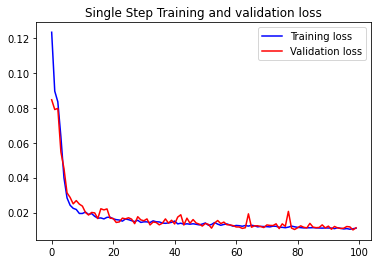

In [566]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

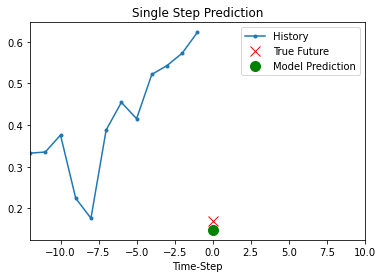

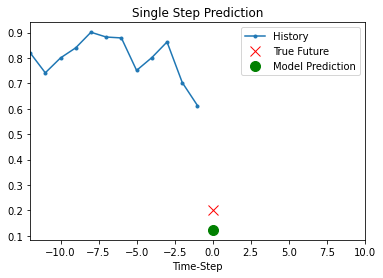

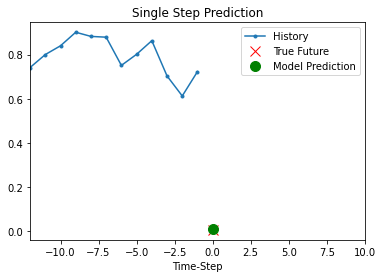

In [567]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 2].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0, 
                   'Single Step Prediction')
  plot.show()

In [568]:
# make prediction 
trainPredict =single_step_model.predict(trainX,batch_size = 64,verbose=1)

114/114 [==============================] - 0s 3ms/step


In [137]:
np.array(trainPredict).shape

(7259, 1)

In [569]:
# make prediction 

testPredict = single_step_model.predict(testX, batch_size = 64,verbose=1) 
  
  

33/33 [==============================] - 0s 3ms/step


In [436]:
 trainPredict[:,0].shape

(7259,)

## Calcuate Metrics


In [0]:
def calculate_mape(y_true, y_pred):
    """ Calculate mean absolute percentage error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mpe(y_true, y_pred):
    """ Calculate mean percentage error (MPE)"""
    return np.mean((y_true - y_pred) / y_true) * 100

def calculate_mae(y_true, y_pred):
    """ Calculate mean absolute error (MAE)"""
    return np.mean(np.abs(y_true - y_pred), axis = 1) 

def calculate_rmse(y_true, y_pred):
    """ Calculate root mean square error (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def print_error_metrics(y_true, y_pred):
    print('MAPE: %f'%calculate_mape(y_true, y_pred))
    print('MPE: %f'%calculate_mpe(y_true, y_pred))
    print('MAE: %f'%calculate_mae(y_true, y_pred))
    print('RMSE: %f'%calculate_rmse(y_true, y_pred))
    return

In [589]:
np.mean(np.abs(trainY_.T - trainPredict_.T))

1935.1742740500883

In [441]:
trainY[0:10]

array([0.08128379, 0.08550055, 0.09292823, 0.07253402, 0.07649822,
       0.08620831, 0.0816889 , 0.07962012, 0.08017224, 0.08019394])

In [0]:
trainY_ = data_min[0] + (data_max[0] - data_min[0])*trainY



In [443]:
trainY_[:10]

array([16555.11, 17413.94, 18926.74, 14773.04, 15580.43, 17558.09,
       16637.62, 16216.27, 16328.72, 16333.14])

In [0]:
trainPredict_ = data_min[0] + (data_max[0] - data_min[0])*trainPredict

In [446]:
trainPredict_[:10]

array([[15070.636],
       [17619.75 ],
       [15044.565],
       [15807.555],
       [16317.884],
       [16617.604],
       [16807.74 ],
       [16745.533],
       [16507.13 ],
       [16085.377]], dtype=float32)

In [0]:

testY_ = data_min[0] + (data_max[0] - data_min[0])*testY
testPredict_ = data_min[0] +  (data_max[0] - data_min[0])*testPredict


In [468]:
testY_[:10]

array([34684.21, 16976.19, 16347.6 , 17147.44, 18164.2 , 18517.79,
       16963.55, 16065.49, 17666.  , 17558.82])

In [471]:
testPredict_[:10]

array([[25329.416],
       [24644.826],
       [22894.38 ],
       [21553.123],
       [20036.184],
       [19266.922],
       [18878.258],
       [18445.611],
       [18078.736],
       [17924.754]], dtype=float32)

In [578]:
trainY_[:10]

array([16555.11, 17413.94, 18926.74, 14773.04, 15580.43, 17558.09,
       16637.62, 16216.27, 16328.72, 16333.14])

In [579]:
trainPredict_[:10]

array([[16897.26 ],
       [17556.314],
       [15505.284],
       [15547.154],
       [15592.684],
       [16288.574],
       [16779.316],
       [16304.322],
       [15742.861],
       [15306.354]], dtype=float32)

In [0]:
df_output = pd.DataFrame()
df_output['Trainoriginal']= trainY_
df_output['Trainpred'] = trainPredict_
df_output.to_csv('Predtrain.csv')


In [0]:
df_output = pd.DataFrame()
df_output['Testoriginal']= testY_
df_output['Testpred'] = testPredict_
df_output.to_csv('Predtest.csv')

In [0]:
# metrics for Train dataset
print_error_metrics(trainY_.T, trainPredict_.T)


MAPE: inf
MPE: -inf
MAE: 1935.174274
RMSE: 4428.078475


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [591]:
#metrics for test dataset
print_error_metrics(testY_.T, testPredict_.T)


MAPE: inf
MPE: -inf
MAE: 2464.720207
RMSE: 4179.725726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(0, 0.5, 'Actual Weekly Sales')

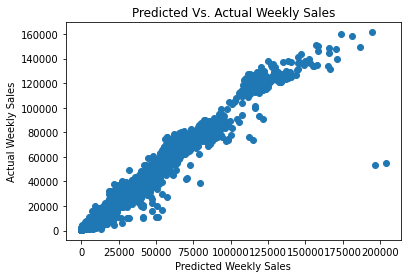

In [576]:
plt.scatter(trainY_, trainPredict_[:,])
plt.title('Predicted Vs. Actual Weekly Sales')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Actual Weekly Sales')
#plt.xlim(-1, 15)
#plt.ylim(-1, 15)


Text(0, 0.5, 'Actual Weekly Sales')

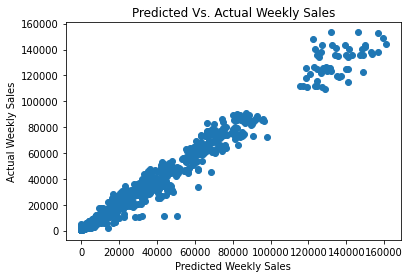

In [577]:
plt.scatter(testY_, testPredict_[:,])
plt.title('Predicted Vs. Actual Weekly Sales')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Actual Weekly Sales')

In [451]:
from sklearn.metrics import r2_score
r2_score(testY, testPredict[:,0])

0.97407974974928

In [0]:
testPredict.shape

(48641, 1)

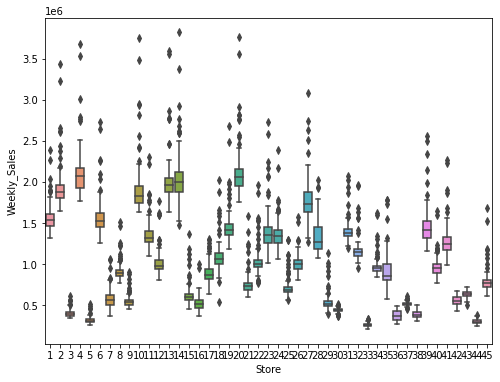

In [0]:
data = pd.concat([df_store_weeklysales['Store'], df_store_weeklysales['Weekly_Sales']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data)


# 3. Our winner is Multivariate Recurrent Neural Network with with R square around 98% and RSME of 2k.